In [ ]:
import json

with open('/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json', 'r') as file:
    podaci = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json'

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/panoptic

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic


In [3]:
!pip install pycocotools

In [15]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 20.5 MB/s eta 0:00:00


## Definisanje modela

In [4]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
import cv2
from pycocotools.coco import COCO
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import ResNet50_Weights

In [5]:
TRAIN_ANNOTATION = './archive/training_and_validation/train.json'
VAL_ANNOTATION = './archive/training_and_validation/val.json'
TEST_ANNOTATION = './archive/test/import-videos/ann/instances.json'
IMAGES_DIR = './archive/images/'
MODEL_DIR_PATH = './output/mask_rcnn_models/'

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root, annotation_files, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco_datasets = [COCO(annotation_file) for annotation_file in annotation_files]
        self.img_ids = []
        for coco in self.coco_datasets:
            self.img_ids.extend(list(coco.imgs.keys()))
        self.img_ids = list(set(self.img_ids))


    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        for coco in self.coco_datasets:
            if img_id in coco.imgs:
                img_info = coco.loadImgs(img_id)[0]
                ann_ids = coco.getAnnIds(imgIds=img_id)
                anns = coco.loadAnns(ann_ids)
                break

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        masks = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            mask = coco.annToMask(ann)
            masks.append(mask)
            areas.append(ann['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in anns], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)

def get_instance_segmentation_model(num_classes):
    backbone = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
    backbone.out_channels = 2048

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    model = MaskRCNN(backbone,
                     num_classes=num_classes,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler)

    return model

In [7]:


def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    mAPs = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images, targets)

            if isinstance(outputs, dict):
                loss_dict = outputs
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()
                num_batches += 1
                outputs = model(images)  # Re-run to get predictions

            for i, output in enumerate(outputs):
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                pred_class_ids = outputs[i]['labels'].cpu().numpy()
                pred_scores = outputs[i]['scores'].cpu().numpy()
                pred_masks = outputs[i]['masks'].cpu().numpy().squeeze(1)

                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_class_ids = targets[i]['labels'].cpu().numpy()
                gt_masks = targets[i]['masks'].cpu().numpy()

                # funkija koja ce racunati AP
                mAPs.append(AP)


    mean_loss = total_loss / num_batches if num_batches > 0 else float('nan')
    mean_APs = sum(mAPs) / len(mAPs)

    return mean_loss, mean_APs

ovo je privremeno

In [24]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, data_loader, device):
    model.to(device)
    model.eval()
    total_loss = 0.0
    num_batches = 0
    metric = MeanAveragePrecision()

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images, targets)

            if isinstance(outputs, dict):
                loss_dict = outputs
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()
                num_batches += 1
                outputs = model(images)

            for i, output in enumerate(outputs):
                preds = [{
                    'boxes': outputs[i]['boxes'].cpu(),
                    'scores': outputs[i]['scores'].cpu(),
                    'labels': outputs[i]['labels'].cpu(),
                }]

                gts = [{
                    'boxes': targets[i]['boxes'].cpu(),
                    'labels': targets[i]['labels'].cpu(),
                }]

                metric.update(preds, gts)

    mean_loss = total_loss / num_batches if num_batches > 0 else float('nan')
    mAP = metric.compute()

    return mean_loss, mAP['map']

## Treniranje i testiranje modela

In [14]:
def train(train_loader, val_loader, num_classes):
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = 'cuda'

    model = get_instance_segmentation_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    num_epochs = 10
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()


        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch loss: {epoch_loss}")
        train_losses.append(epoch_loss)

        val_epoch_loss, val_mAP = evaluate(model, val_loader, device)
        print(f"Validation loss: {val_epoch_loss}\nValidation mAP: {val_mAP}")

        val_losses.append(val_epoch_loss)
        lr_scheduler.step()

    print("Training complete")
    return model, train_losses, val_losses

In [10]:
def test(model, device, data_path, annotation_paths):
    dataset = CustomDataset(data_path, annotation_paths, transforms=T.Compose([T.ToTensor()]))
    data_loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

    mean_loss, mean_mAP = evaluate(model, data_loader, device)
    print(f'Mean mAP: {mean_mAP}')

In [11]:
def plot_losses(train_losses, val_losses):
    epochs = [i for i in range(1, len(val_losses)+1)]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs - MASK RCNN')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()

In [18]:
# training and validation data
train_dataset = CustomDataset(IMAGES_DIR, [
    TRAIN_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

val_dataset = CustomDataset(IMAGES_DIR, [
    VAL_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [16]:
train(train_loader, val_loader, 8)

Epoch 1/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch loss: 1.1664639053287766
(22, 1080, 1920)
(42, 1, 1080, 1920)


ValueError: shapes (42,45360) and (23760,22) not aligned: 45360 (dim 1) != 23760 (dim 0)

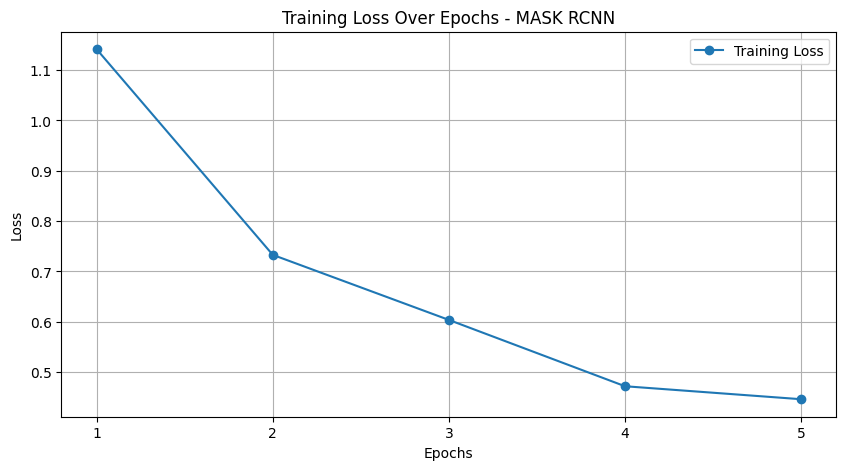

In [ ]:
# Run this cell to start training
model, train_losses, val_losses = train(train_loader, val_loader, 8)

torch.save(model.state_dict(), )
plot_losses(train_losses, val_losses)

In [ ]:
test(model, 'cuda', data_path=IMAGES_DIR, annotation_paths=[TEST_ANNOTATION])

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(6, 1080, 1920)
(2, 1, 1080, 1920)


ValueError: shapes (2,2160) and (6480,6) not aligned: 2160 (dim 1) != 6480 (dim 0)

## Predikcije na novim slikama

In [ ]:
categories = {
    1: "Player",
    2: "Ball",
    3: "Goal Line",
    4: "Field",
    5: "Background",
    6: "Referee",
    7: "Football Pitch Line",
}

# setting model priorities for properly mask drawing
priorities = {
    1 : 6, # player
    2 : 7, # ball
    3 : 4, # goal line
    4 : 2, # field
    5 : 1, # background
    6 : 5, # refree
    7 : 3, # pitch line
    0 : 0
}

In [ ]:
def load_model(model_path, num_classes):
    model = get_instance_segmentation_model(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    image = Image.open(image_path).convert("RGB")

    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        prediction = model(image_tensor.to(device))

    return image, prediction

In [ ]:
model = load_model(MODEL_DIR_PATH + 'mask_rcnn_1', 8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [ ]:
def set_priorities(prediction, priorities):
    predictions_with_priorities = []
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label_id = int(prediction[0]['labels'][element].cpu().numpy())
        mask = prediction[0]['masks'][element, 0].cpu().numpy()
        priority = priorities.get(label_id, 0)
        predictions_with_priorities.append((priority, box, score, label_id, mask))

    predictions_with_priorities.sort(key=lambda x: x[0])
    return predictions_with_priorities

def predict_and_visualize(image_path, model, device, draw_mask = True, draw_box = True):

    image, prediction = predict(model, image_path, device)

    predictions_with_priorities = set_priorities(prediction, priorities)

    combined_mask = np.zeros_like(image, dtype=np.float32)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    if draw_mask:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                mask = mask > 0.5
                random_color = np.random.rand(3)
                colored_mask = np.zeros((*mask.shape, 3))
                colored_mask[mask] = random_color
                combined_mask[mask] = random_color


        combined_mask = np.clip(combined_mask, 0, 1)
        ax.imshow(combined_mask, alpha=0.5)

    if draw_box:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1] - 10, f'{label}: {score:.2f}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

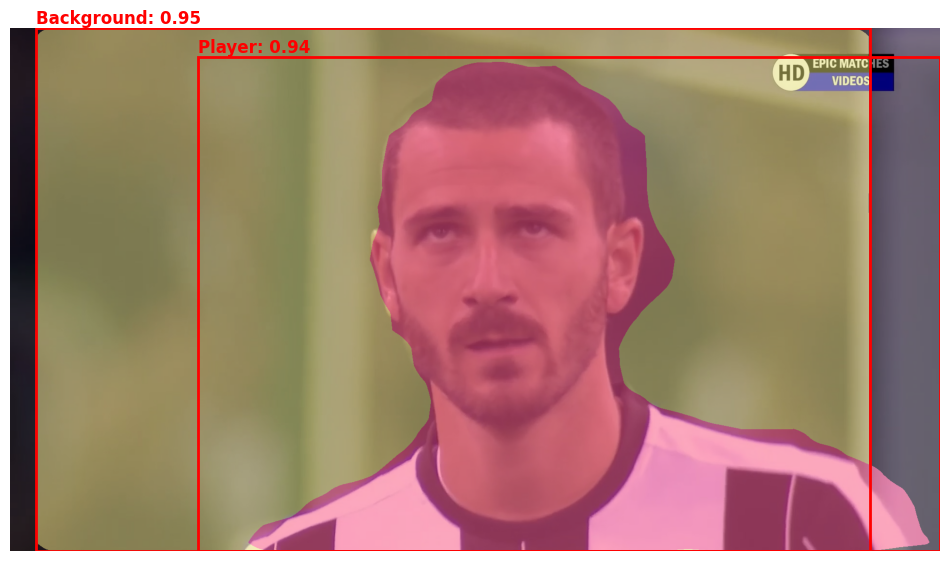

In [ ]:
predict_and_visualize("./archive/images/Football batch 1.mp4_00001.jpg", model, device, draw_box=True, draw_mask=True)